## 영화 관객수 예측 모델 개발
### 1. movies_train.csv / movies_test.csv
- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### 2.  submission.csv (제출 파일 형식)

### 3. 데이터 상세 설명
- 2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터



#### `1.` 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt                     # 이상치 확인을 위해 시각화에 필요한 라이브러리 임포트
import seaborn as sns
from sklearn.preprocessing import LabelEncoder      # 데이터 인코딩 함수
from sklearn.impute import SimpleImputer            # 결측치 처리
from sklearn import linear_model                    # 결측치 처리를 위한 선형 회귀 모델 생성
from sklearn.model_selection import KFold           # 모델의 교차검증을 위해 임포트합니다.
from sklearn.metrics import r2_score                # 
from sklearn.model_selection import GridSearchCV    # 최적의 파라미터를 찾기 위한 함수입니다.

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### `2.` 데이터 로드

In [2]:
train_data = pd.read_csv('./영화 관객수/movies_train.csv')
test_data = pd.read_csv('./영화 관객수/movies_test.csv')
submission = pd.read_csv('./영화 관객수/submission.csv')

#### `3.` 데이터 기본 정보 확인

In [3]:
display(train_data)
print(train_data.info())
display(test_data)
print(test_data.info())

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
None


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB
None


#### `4.` 데이터 전처리: 이상치 확인 및 제거

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


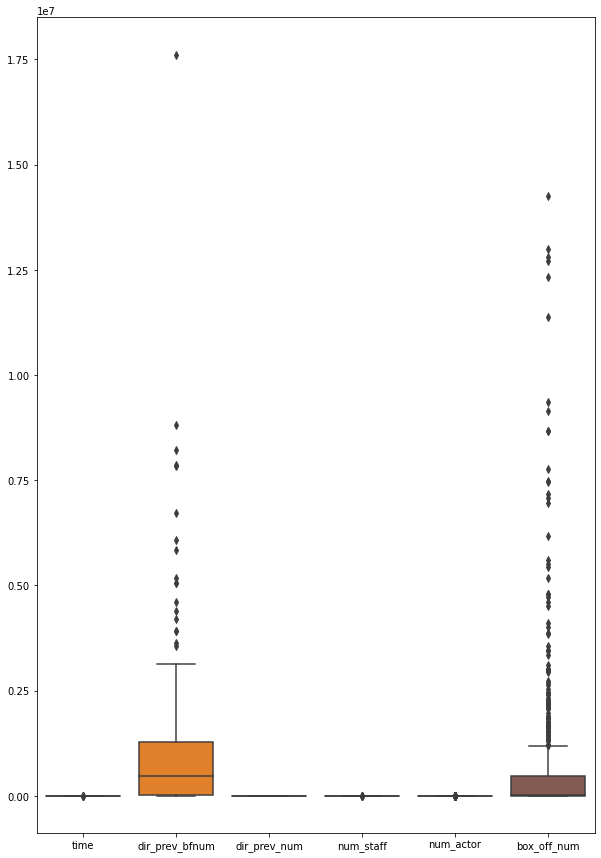

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 597
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           503 non-null    object 
 1   distributor     503 non-null    object 
 2   genre           503 non-null    object 
 3   release_time    503 non-null    object 
 4   time            503 non-null    int64  
 5   screening_rat   503 non-null    object 
 6   director        503 non-null    object 
 7   dir_prev_bfnum  194 non-null    float64
 8   dir_prev_num    503 non-null    int64  
 9   num_staff       503 non-null    int64  
 10  num_actor       503 non-null    int64  
 11  box_off_num     503 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 51.1+ KB
None


In [4]:
# 학습 데이터의 기술 정보를 확인합니다.
display(train_data.describe())

# 이상치를 시각화하여 확인합니다.
plt.figure(figsize=(10, 15))
sns.boxplot(data=train_data)
plt.show()

# 이상치 제거 클래스 입니다.
def get_outlier(df=None, column=None, weight=1.5):
    
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx = get_outlier(df=train_data, column='box_off_num', weight=1.5)
train_data.drop(outlier_idx, axis=0, inplace=True)

# 이상치 제거 후 정보를 확인합니다.
print(train_data.info())

#### `5.` 데이터 전처리: 레이블 인코딩

In [5]:
# 상관관계를 확인하고 결측값을 해결하기 위해 인코딩을 먼저 진행하겠습니다.
# 학습 데이터와 테스트 데이터 간 데이터가 상이하여 인코더 객체를 각각 만들어 인코딩 하였습니다.
encoder1 = LabelEncoder() # 트레인용 인코더
encoder2 = LabelEncoder() # 테스트용 인코더

# 인코딩할 특성의 이름을 리스트로 변수에 할당합니다.
# 리스트에 할당된 특성의 이름으로 train_data의 각 특성을 하나씩 인코딩 합니다.
for i in ['title', 'distributor', 'genre', 'screening_rat', 'release_time', 'director'] :
    train_data[i] = encoder1.fit_transform(train_data[i])

# 리스트에 할당된 특성의 이름으로 test_data의 각 특성을 하나씩 인코딩 합니다.
for i in ['title', 'distributor', 'genre', 'screening_rat', 'release_time', 'director'] :
    test_data[i] = encoder2.fit_transform(test_data[i])
    
# 인코딩 후 데이터를 확인합니다.
display(train_data)
display(test_data)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,22,78,10,118,96,3,342,NaN,0,91,2,23398
3,75,6,11,100,101,2,14,23894.0,2,20,6,217866
4,222,94,11,34,108,1,191,1.0,1,251,2,483387
5,20,78,11,114,113,1,225,837969.0,2,262,4,233211
6,64,88,3,135,104,2,276,NaN,0,32,5,53526
...,...,...,...,...,...,...,...,...,...,...,...,...
590,401,50,7,47,114,3,345,NaN,0,92,2,1250
591,297,109,11,146,101,3,175,NaN,0,59,4,14188
593,90,155,7,148,97,3,368,NaN,0,5,3,1132
594,332,17,11,173,94,3,111,NaN,0,37,5,1958


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,153,64,2,0,125,3,56,3.005290e+05,2,304,3
1,133,16,5,1,113,0,126,3.427002e+05,4,275,3
2,219,29,4,2,115,0,0,4.206611e+06,3,419,7
3,171,16,10,3,116,1,175,6.913420e+05,2,408,2
4,213,29,1,4,110,1,16,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,227,42,4,178,78,1,107,2.590000e+03,1,4,4
239,161,80,3,177,86,0,147,NaN,0,18,2
240,138,23,2,176,107,3,108,NaN,0,224,4
241,77,18,4,175,102,3,97,5.069900e+04,1,68,7


#### `6-1.` 데이터 전처리: 결측치 치환

In [6]:
# dir_prev_bfnum 특성의 결측치가 있는 행의 dir_prev_num 특성 행을 보면 모두 0임을 알 수 있습니다.
# 이전에 영화를 만들어본적이 없는 사람이어서 이전 관객수가 결측값으로 나온 것일 수 있겠다 라는 의심이 생겨
# 확인해보겠습니다. dir_prev_bfnum 열의 결측값이 있는 행의 dir_prev_num 열을 모두 더해봅니다.
# 합산 결과 0으로 결측값이 있는 행은 dir_prev_num 특성도 0임을 확인할 수 있었습니다.
print(train_data[train_data['dir_prev_bfnum'].isna()]['dir_prev_num'].sum())

# dir_prev_bfnum 특성의 결측값을 0으로 치환합니다.
train_data['dir_prev_bfnum'].fillna(0, inplace=True)
test_data['dir_prev_bfnum'].fillna(0, inplace=True)

# 치환 후 데이터를 확인합니다.
display(train_data)
display(test_data)

0


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,22,78,10,118,96,3,342,0.0,0,91,2,23398
3,75,6,11,100,101,2,14,23894.0,2,20,6,217866
4,222,94,11,34,108,1,191,1.0,1,251,2,483387
5,20,78,11,114,113,1,225,837969.0,2,262,4,233211
6,64,88,3,135,104,2,276,0.0,0,32,5,53526
...,...,...,...,...,...,...,...,...,...,...,...,...
590,401,50,7,47,114,3,345,0.0,0,92,2,1250
591,297,109,11,146,101,3,175,0.0,0,59,4,14188
593,90,155,7,148,97,3,368,0.0,0,5,3,1132
594,332,17,11,173,94,3,111,0.0,0,37,5,1958


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,153,64,2,0,125,3,56,3.005290e+05,2,304,3
1,133,16,5,1,113,0,126,3.427002e+05,4,275,3
2,219,29,4,2,115,0,0,4.206611e+06,3,419,7
3,171,16,10,3,116,1,175,6.913420e+05,2,408,2
4,213,29,1,4,110,1,16,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,227,42,4,178,78,1,107,2.590000e+03,1,4,4
239,161,80,3,177,86,0,147,0.000000e+00,0,18,2
240,138,23,2,176,107,3,108,0.000000e+00,0,224,4
241,77,18,4,175,102,3,97,5.069900e+04,1,68,7


#### `6-2` 데이터 전처리: 결측치 처리(선형 회귀 모델)  ※치환보다 성능 낮음※

In [7]:
# # 결측값의 비율이 전체 데이터의 55%로 그 비율이 상당히 높으나 상관계수가 높아 치환하여 사용하겠습니다. 
# # 선형회귀 알고리즘을 사용하여 결측치 치환을 진행하였습니다.
# lin_reg_model = linear_model.LinearRegression()

# # 결측값이 존재하는 특성은 dir_prev_bfnum 특성 하나로 원본 데이터에서 dir_prev_bfnum 특성에 NaN값이 있는 행을 삭제 하고
# # dir_prev_bfnum 특성을 타깃으로 상관계수가 적은 release_time 특성을 제외한 나머지 특성을 피쳐로 사용합니다.
# train_data_51 = train_data.dropna(axis=0)
# feature_train_51 = train_data_51.drop(columns=['dir_prev_bfnum', 'release_time'], axis=1)
# targit_train_51 = train_data_51['dir_prev_bfnum']

# # 원본 데이터에서 결측값이 존재하는 행을 예측에 이용할 테스트 데이터로 사용합니다.
# test_data_51 = train_data.drop(index=train_data[train_data['dir_prev_bfnum'].isnull() != 1].index)
# feature_test = test_data_51.drop(['dir_prev_bfnum', 'release_time'], axis=1)

# # # 선형 회귀 모델의 학습을 시킵니다.
# lin_reg_model = lin_reg_model.fit(feature_train_51, targit_train_51)

# # 예측을 진행합니다.
# pred_non = lin_reg_model.predict(feature_test)

# # 예측한 데이터를 바탕으로 결측값을 채워나갑니다.
# train_data.loc[test_data_51.index, 'dir_prev_bfnum'] = pred_non
# print(train_data.info())

#### `7.` 데이터 전처리: 드랍

In [8]:
# 인코딩한 결과물로 타깃값인 box_off_num을 기준으로 상관관계를 확인해보겠습니다.
print('----------box_off_num의 상관관계----------')
corr = train_data.corr()
print(corr['box_off_num'].sort_values(ascending=False))

# 모델의 연산비용을 줄이기 위해 위 상관관계에서 5% 미만의 계수를 가진 특성은 드랍하겠습니다.
train_data.drop(columns=['title'], inplace=True)
test_data.drop(columns=['title'], inplace=True)

# 해당 특성의 경우 날짜 전체를 인코딩 한것과 연월일로 나누어 인코딩 후 학습을 해본 결과 상관계수도 적을뿐더러
# 모델의 가해지는 영향이 미세하기 때문에 드랍하기로 결정하였습니다.
train_data.drop(columns=['release_time'], inplace=True)
test_data.drop(columns=['release_time'], inplace=True)

----------box_off_num의 상관관계----------
box_off_num       1.000000
num_staff         0.655384
time              0.369108
dir_prev_num      0.321703
dir_prev_bfnum    0.178051
genre             0.114356
title             0.052079
num_actor         0.021553
director          0.008678
release_time     -0.054966
distributor      -0.120809
screening_rat    -0.195849
Name: box_off_num, dtype: float64


#### `8.` 데이터 조정: 피쳐와 타겟 분리

In [9]:
# 모델의 학습을 할 데이터를 조정합니다.
# 피쳐로 사용할 데이터는 타깃값을 드랍한 나머지 특성을 전달합니다.
feature_train = train_data.drop(['box_off_num'], axis=1)
feature_test = test_data

# 타겟으로 사용할 원본 데이터의 box_off_num 열을 넘겨줍니다.
target_train = train_data['box_off_num']

#### `9.` 모델 구축 및 파라미터 튜닝과 교차 검증 평가

In [10]:
# 관객수를 구하는것은 연속된 값으로 리그레션을 사용하겠습니다.
# 해당 모델은 과적합의 위험이 매우 높으므로 모델 구축 후 반드시 과적합을 방지하는 과정들이 필요합니다.
model = lgb.LGBMRegressor(random_state=23, n_estimators=1000, learning_rate=0.001, min_child_samples=30)

# 교차 검증을 위해 데이터를 나누겠습니다. 5번의 교차검증 즉 데이터를 5등분 하겠습니다.
# 먼저 데이터 나누기를 도와줄 KFold 객체를 k_fold 변수에 할당합니다.
# n_splits=: 교차 검증을 몇번 할 것인가 즉 데이터를 몇 등분할것인가를 정합니다.
k_fold = KFold(n_splits=5, shuffle = True, random_state=23)

# KFold 객체에 split() 함수를 호출하면 폴드별 학습과 테스트 데이터의 행 인덱스를 배열로 반환합니다.
model_score = [] # 폴드 세트별 정확도 값을 저장할 리스트 변수 입니다.
for train_idx, test_idx in k_fold.split(feature_train) : # feature_train
    x_train, x_test = feature_train.iloc[train_idx], feature_train.iloc[test_idx] # feature_train
    y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]
    
    # 나누어진 데이터로 모델 학습과 예측을 진행합니다.
    # eval_set=: 검증 데이터셋을 지정합니다 학습은 train 데이터로 하나 검증은 test 데이터로 하라는 뜻입니다.
    # early_stopping_rounds=: 지정한 횟수동안 개선이 없으면 강제로 종료하라는 뜻입니다.
    # verbose=: 
    model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=100, verbose=100)
    model_pred = model.predict(x_test)
#     model_pred = model.predict(x_train)
    
    # 정확도를 측정합니다.
    model_score = np.round(r2_score(y_test, model_pred), 4)
#     model_score = np.round(r2_score(y_train, model_pred), 4)

# 개별 세트별로 측정한 정확도를 합하여 평균 정확도를 계산합니다.
print('r2: ', np.mean(model_score))

C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 7.91856e+10
[200]	valid_0's l2: 7.50888e+10
[300]	valid_0's l2: 7.13573e+10
[400]	valid_0's l2: 6.83479e+10
[500]	valid_0's l2: 6.58268e+10
[600]	valid_0's l2: 6.37955e+10
[700]	valid_0's l2: 6.21199e+10
[800]	valid_0's l2: 6.07165e+10
[900]	valid_0's l2: 5.95616e+10
[1000]	valid_0's l2: 5.85884e+10
[100]	valid_0's l2: 4.16769e+10
[200]	valid_0's l2: 3.84873e+10


C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's l2: 3.60756e+10
[400]	valid_0's l2: 3.42372e+10
[500]	valid_0's l2: 3.28574e+10
[600]	valid_0's l2: 3.18798e+10
[700]	valid_0's l2: 3.12212e+10
[800]	valid_0's l2: 3.08437e+10
[900]	valid_0's l2: 3.06181e+10
[1000]	valid_0's l2: 3.05075e+10
[100]	valid_0's l2: 8.24157e+10
[200]	valid_0's l2: 7.71527e+10
[300]	valid_0's l2: 7.28363e+10


C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's l2: 6.91403e+10
[500]	valid_0's l2: 6.58609e+10
[600]	valid_0's l2: 6.31438e+10
[700]	valid_0's l2: 6.08854e+10
[800]	valid_0's l2: 5.90057e+10
[900]	valid_0's l2: 5.74565e+10
[1000]	valid_0's l2: 5.61378e+10
[100]	valid_0's l2: 4.63849e+10
[200]	valid_0's l2: 4.22312e+10
[300]	valid_0's l2: 3.89421e+10
[400]	valid_0's l2: 3.62988e+10


C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's l2: 3.42111e+10
[600]	valid_0's l2: 3.2518e+10
[700]	valid_0's l2: 3.11256e+10
[800]	valid_0's l2: 3.00341e+10
[900]	valid_0's l2: 2.91743e+10
[1000]	valid_0's l2: 2.84704e+10


C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\HPE\anaconda3\envs\K-Digital_Training\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 6.72531e+10
[200]	valid_0's l2: 6.16894e+10
[300]	valid_0's l2: 5.7057e+10
[400]	valid_0's l2: 5.31761e+10
[500]	valid_0's l2: 4.99074e+10
[600]	valid_0's l2: 4.71812e+10
[700]	valid_0's l2: 4.48992e+10
[800]	valid_0's l2: 4.29784e+10
[900]	valid_0's l2: 4.13624e+10
[1000]	valid_0's l2: 3.99926e+10
r2:  0.4547


In [11]:
# 그리드 서치로 최적의 파라미터를 찾습니다.
params = {'learning_rate': [0.1, 0.01, 0.001], 'min_child_samples': [20, 30, 40]}

# estimator: 적용할 모델 등을 지정합니다.
# param_grid: 튜닝을 위해 파라미터를 지정합니다. 리스트 형식으로 변수에 할당해서 사용합니다.
# scoring: 예측 성능을 측정할 평가 방법을 지정합니다. 보통 accuracy 로 지정하여서 정확도로 성능 평가를 합니다. 
# cv: 교차 검증에서 몇개로 분할되는지 지정합니다.
gr_se = GridSearchCV(estimator=model, 
                     param_grid = params,
                     scoring = 'neg_mean_squared_error',
                     cv=k_fold)

# 학습합니다.
gr_se.fit(x_train, y_train)

# 최적의 파라미터를 출력합니다.
print(gr_se.best_params_)

{'learning_rate': 0.001, 'min_child_samples': 30}


In [13]:
선형 회귀 모델 r2 : 0.2572
0으로 치환 : 0.2607
이상치 제거 후 0으로 치환(학습 데이터) : 0.5865
이상치 제거 후 0으로 치환(테스트 데이터) : 0.6845

SyntaxError: invalid syntax (2759545978.py, line 1)

In [ ]:
https://github.com/Yiujin/DACON/blob/main/%EC%98%81%ED%99%94%EA%B4%80%EA%B0%9D%EC%88%98%EC%98%88%EC%B8%A1%EC%97%B0%EC%8A%B5/%EC%98%81%ED%99%94.ipynb

#### `번외` 완성본에서는 제외 되었으나 중간에 사용한 코드입니다.

In [ ]:
# train_data에 year, month, day 특성을 추가하고 release_time을 '-'을 기준으로 나누어 할당합니다.
# 각 특성에 타입을 object → int로 변환해줍니다.
train_data['year'], train_data['month'], train_data['day'] = train_data['release_time'].str.split('-').str
for i in ['year', 'month', 'day'] :
    train_data[i] = train_data[i].astype(int)
    
# 원-핫 인코딩을 진행합니다.
for i in ['distributor', 'genre', 'screening_rat', 'director'] :
    pd.get_dummies(feature_train, columns=[i])
    
for i in ['distributor', 'genre', 'screening_rat', 'director'] :
    pd.get_dummies(feature_test, columns=[i])